# Домашнее задание к вебинару 2 "Создание признакового пространства"

Постановка задачи: классификация твитов по тональности

Есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

In [3]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 8.2 MB 10.0 MB/s 


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from string import punctuation

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from string import punctuation
from nltk.stem import WordNetLemmatizer

from collections import Counter

from pymorphy2 import MorphAnalyzer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import warnings
warnings.filterwarnings("ignore")

In [5]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2022-05-31 16:04:18--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2022-05-31 16:04:18--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf8da5b14b1e3dbb9147226dbfb.dl.dropboxusercontent.com/cd/0/inline/BmXY4hAXAKzmarkkR4oFhMbQQbAMB90e0qmU9fE5CV7rOHNOdgr1O4woiDvk7HitrqzHHqzQmQVpoovXKBizfTgV6HCkYGoDfkCbvY-8eF-g4IBGMJ6zNVBm4Ruo3x7YMGe0NHfOyHIT7FG16Vb2z31OSPf524ncc6JDKglkm0YOJg/file# [following]
--2022-05-31 16:04:18--  https://ucf8da5b14b1e3dbb9147226dbfb.dl.dropboxusercontent.com/cd/0/inline/BmXY4hAXAKzmarkkR4oFhMbQQbAMB90e0qmU9fE5CV7rOHNOdgr1O4woiDvk7HitrqzH

In [6]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [7]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2859142


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [13]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69267),
 ('и', 54916),
 ('в', 52853),
 ('я', 52506),
 ('RT', 38070),
 ('на', 35715),
 ('http', 32992),
 ('что', 31472),
 ('...', 28773),
 ('с', 27176)]

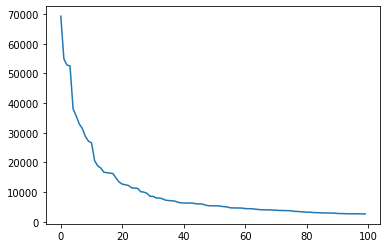

In [14]:
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

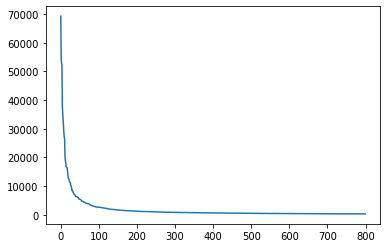

In [15]:
%matplotlib inline
first_800_freqs = [freq for word, freq in freq_dict_sorted[:800]]
plt.plot(first_800_freqs)
plt.show()

In [16]:
freq_dict_800 = sorted(freq_dict.items(), key=lambda x: -x[1])[:800]

In [18]:
pymorphy2_analyzer = MorphAnalyzer()

In [19]:
def text_preparation(text, start_board, end_board):
    tokens = word_tokenize(text)
    return [token for token in tokens if token in [item[0] for item in freq_dict_800][start_board:end_board] 
            and token not in punctuation]

In [20]:
# Пример использования
stroka = 'Мама не и мыла раму'

In [21]:
text_preparation(stroka, 0, 10)

['не', 'и']

In [22]:
# 1) Классификатор на токенах с высокой частотой
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda x: text_preparation(x, 0, 150))
x_train_bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(x_train_bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.61      0.62      0.62     27129
    positive       0.65      0.64      0.64     29580

    accuracy                           0.63     56709
   macro avg       0.63      0.63      0.63     56709
weighted avg       0.63      0.63      0.63     56709



In [23]:
# 2) Классификатор на токенах со средней частотой
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda x: text_preparation(x, 151, 350))
x_train_bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(x_train_bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))


              precision    recall  f1-score   support

    negative       0.37      0.60      0.46     17029
    positive       0.77      0.56      0.65     39680

    accuracy                           0.57     56709
   macro avg       0.57      0.58      0.55     56709
weighted avg       0.65      0.57      0.59     56709



In [24]:
# 3) Классификатор на токенах с низкой частотой
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda x: text_preparation(x, 351, 800))
x_train_bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(x_train_bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.37      0.65      0.47     15621
    positive       0.81      0.57      0.67     41088

    accuracy                           0.59     56709
   macro avg       0.59      0.61      0.57     56709
weighted avg       0.69      0.59      0.62     56709



Наилучший результат показала модель, обучающаяся на высокочастотных токенах, значит они наиболее важны.

## Задание 2.

**Классификация без удаления пунктуации**

In [25]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
x_train_bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(x_train_bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27730
    positive       1.00      1.00      1.00     28979

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



**Найти фичи с наибольшей значимостью, и вывести их**

In [26]:
feature_names = vec.get_feature_names()
feature_names

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 '(',
 ')',
 '*',
 '**',
 '***',
 '****',
 '*****',
 '******',
 '*******',
 '********',
 '*********',
 '**********',
 '***********',
 '************',
 '*************',
 '**************',
 '***************',
 '********************************',
 '**********************************************',
 '*************************************************************************************************************',
 '***************************************_',
 '***************♥♥♥♥♥♥',
 '**************…',
 '******е',
 '******…',
 '****горжусь',
 '****но',
 '****очень',
 '***888*8888*88**88*',
 '***999',
 '***ахах',
 '***всего',
 '***домаусебявкомнате***',
 '***иначе',
 '***кот***просто***кот***',
 '***люплю',
 '***обожаю',
 '***омана',
 '***поздравляшкииии:3',
 '***сегодня',
 '***ты',
 '***я',
 '***ярких',
 '**..**',
 '**7',
 '**8*88**',
 '**азааз',
 '**афигенская',
 '**взаимно',
 '**ещё',
 '**иди',
 '**й',
 '**некрытик',
 '**но',
 '**о**',
 '**поттерома

In [27]:
count_feature = Counter(feature_names)
count_feature_sort = sorted(count_feature.items(), key=lambda x: x[1])
list(count_feature_sort)[:10]

[('!', 1),
 ('#', 1),
 ('$', 1),
 ('%', 1),
 ('&', 1),
 ("'", 1),
 ("''", 1),
 ('(', 1),
 (')', 1),
 ('*', 1)]

Абсолютно неудивительно, что среди наиболее частых токенов оказались знаки пунктуации, ведь их используют бувально в каждом предложении, особенно в русском языке. Посмотрим, сможет ли один и из таких токенов справиться с классификацией без помощи машинного обучения:

In [28]:
cool_token = '!'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.87      0.50      0.64     48293
    positive       0.17      0.58      0.26      8416

    accuracy                           0.51     56709
   macro avg       0.52      0.54      0.45     56709
weighted avg       0.77      0.51      0.58     56709



Токены - знаки пунктуации также становятся наиболее частотными токенами, но они не всегда могут поспособствовать улучшению результата модели из-за их частого использования в письменной речи

**Теперь в качестве фичей используем, например, униграммы символов:**

In [29]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
x_train_bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(x_train_bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     27659
    positive       1.00      0.99      1.00     29050

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Мы можем обучаться на униграммах, но в данной задаче это не лучшая идея. Такой подход отлично подойдет к такому типу задач, как, например, определение языка.

### Задание 3.  
  
**1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)**

In [31]:
# обновим функцию подготовки (токенизации) теста . Будем убирать и стоп-слова, и пунктуацию,
# и делать лемматизацию

import nltk
nltk.download('stopwords')

noise = stopwords.words('russian') + list(punctuation)

def text_preparation(text):
#     tokens = word_tokenize(text)
#     lemmatized_tokens = [pymorphy2_analyzer.parse(token)[0].normal_form for token in tokens]
    return [t for t in [pymorphy2_analyzer.parse(token)[0].normal_form 
                                for token in word_tokenize(text)] if t not in noise]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
# Пример использования
stroka = 'Дети бегают, потому что хотят'
text_preparation(stroka)

['ребёнок', 'бегать', 'хотеть']

In [43]:
# CountVectorizer

c_vec = CountVectorizer(ngram_range=(1, 1), tokenizer = text_preparation)

x_train_bow = c_vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(x_train_bow, y_train)
pred = clf.predict(c_vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.75      0.77     29301
    positive       0.75      0.79      0.77     27408

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [44]:
# TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer = text_preparation)
x_train_bow = tfidf_vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(x_train_bow, y_train)
pred = clf.predict(tfidf_vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     27780
    positive       0.77      0.77      0.77     28929

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [45]:
# HashingVectorizer

h_vec = HashingVectorizer(n_features = 80, tokenizer = text_preparation)
x_train_bow = h_vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(x_train_bow, y_train)
pred = clf.predict(h_vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.63      0.59      0.61     29686
    positive       0.58      0.62      0.60     27023

    accuracy                           0.60     56709
   macro avg       0.61      0.61      0.60     56709
weighted avg       0.61      0.60      0.61     56709



In [53]:
# Полносвязная нейронная сеть

# labelEncode целевую переменную
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

# Создадим Датасет tensorflow
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#Выделим batch-и
train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [58]:
vocab_size = 10000
seq_len = 100

def custom_standardization(input_data):
    return input_data


vectorize_layer = TextVectorization(  
    standardize = custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)


# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [64]:
embedding_dim=200

class myNet(tf.keras.Model):
    def __init__(self):
        super(myNet, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim, name="embedding")
        self.conv1 = Conv1D(200, (3))
        self.conv2 = Conv1D(200, (3))
        self.gPool = GlobalAveragePooling1D()
        self.fc1 = Dense(100, activation='relu')
        self.fc2 = Dense(1)


    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x1 = self.conv1(x)
        x = self.conv2(x)
        x = self.gPool((x + x1)/2)
        x = self.fc1(x)
        return self.fc2(x)

In [69]:
model = myNet()

In [70]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
model.fit(train_data, validation_data=valid_data, epochs=7)

Epoch 1/7
10633/10633 [==============================] - 69s 6ms/step - loss: 0.3889 - accuracy: 0.7763 - val_loss: 0.3504 - val_accuracy: 0.7853
Epoch 2/7
10633/10633 [==============================] - 66s 6ms/step - loss: 0.3268 - accuracy: 0.8187 - val_loss: 0.3489 - val_accuracy: 0.7941
Epoch 3/7
10633/10633 [==============================] - 66s 6ms/step - loss: 0.3053 - accuracy: 0.8321 - val_loss: 0.3594 - val_accuracy: 0.8028
Epoch 4/7
10633/10633 [==============================] - 66s 6ms/step - loss: 0.2851 - accuracy: 0.8452 - val_loss: 0.3948 - val_accuracy: 0.7914
Epoch 5/7
10633/10633 [==============================] - 66s 6ms/step - loss: 0.2618 - accuracy: 0.8618 - val_loss: 0.4714 - val_accuracy: 0.7899
Epoch 6/7
10633/10633 [==============================] - 66s 6ms/step - loss: 0.2385 - accuracy: 0.8764 - val_loss: 0.4681 - val_accuracy: 0.8085
Epoch 7/7
10633/10633 [==============================] - 66s 6ms/step - loss: 0.2195 - accuracy: 0.8884 - val_loss: 0.5374 -

Видно стабильное увеличение метрики от эпохи к эпохе, переобучение не наблюдается

**2) подобрать оптимальный размер для hashing векторайзера**

In [76]:
result = pd.DataFrame(columns=['n_features', 'f1_score_train', 'f1_score_test'])
    
for i in [100, 200, 500, 1000, 2000, 5000]:
    vec = HashingVectorizer(n_features=i, tokenizer=word_tokenize,
                      stop_words=noise)
    x_train_bow = vec.fit_transform(x_train)
    clf.fit(x_train_bow, y_train)
    pred_train = clf.predict(x_train_bow)
    pred_test = clf.predict(vec.transform(x_test))

    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    result = result.append({'n_features': i, 'f1_score_train': f1_train, 'f1_score_test': f1_test}, ignore_index=True)

result.sort_values(by=['f1_score_train'], ascending=False)

,n_features,f1_score_train,f1_score_test
5,5000.0,0.730336,0.708382
4,2000.0,0.690595,0.677867
3,1000.0,0.661447,0.656905
2,500.0,0.639636,0.635131
1,200.0,0.610663,0.612138
0,100.0,0.594628,0.596319


F1 score увеличивается пропорционально росту количества признаков в HashingVectorizer, то есть в данном случае лучшим будет 5000 признаков